# Código para simular limpiar un salón de N x M

**Integrantes**
- A01800766: Jan Francisco Cerón García
- A01800182: Daniel Alvarez Sil

## 1. Importar librerías.

In [126]:
"""
Descripción:
  Módulo del agente y utilidades de visualización para un modelo MESA que limpia
  un cuarto de tamaño N x M. Contiene las dependencias necesarias para el
  espacio discreto, los agentes y la visualización.

Autor(es): Daniel Alvarez Sil, Jan Francisco Cerón García
Fecha: 2025-11-14 (America/Mexico_City)
"""

import numpy as np
import pandas as pd

import mesa

from mesa.discrete_space import CellAgent, OrthogonalMooreGrid
from mesa.visualization import SolaraViz, SpaceRenderer, make_plot_component
from mesa.visualization.components import AgentPortrayalStyle


## 2. Funciones auxiliares.

In [127]:
def percent_clean(model):
    """
    Propósito:
        Calcular el porcentaje de celdas limpias en el cuarto, en función del
        número total de celdas y de las celdas aún sucias.

    Parámetros:
        model (Model): Instancia del modelo MESA que contiene ancho, alto y el
                       contador de celdas sucias.

    Retorna:
        float: Porcentaje de limpieza (0 a 100), donde 100 indica que el cuarto
               está completamente limpio.
    """
    total = model.width * model.height
    return 100.0 * (total - model.dirty_cells) / total


def total_moves(model):
    """
    Propósito:
        Obtener el número total de movimientos realizados por todos los agentes
        durante la simulación.

    Parámetros:
        model (Model): Instancia del modelo que almacena el contador de movimientos.

    Retorna:
        int: Total acumulado de movimientos efectuados por los agentes.
    """
    return model.total_moves


def all_clean(model):
    """
    Propósito:
        Determinar si el cuarto ya está completamente limpio.

    Parámetros:
        model (Model): Instancia del modelo que contiene el número de celdas sucias.

    Retorna:
        bool: True si no quedan celdas sucias, False en caso contrario.
    """
    return model.dirty_cells == 0


## 3. Agente. 

In [128]:
class CleaningAgent(CellAgent):
    """
    Propósito:
        Representar un agente limpiador dentro del modelo. El agente limpia la
        celda donde se encuentra si está sucia; de lo contrario se mueve a una
        celda adyacente seleccionada aleatoriamente. Lleva registro de sus
        movimientos y actualiza los contadores globales del modelo.

    Atributos:
        cell (Cell): Celda actual en la que se encuentra el agente.
        moves (int): Número de movimientos realizados por este agente.
    """

    def __init__(self, model, cell):
        """
        Propósito:
            Inicializar un agente limpiador asignándole una celda inicial y
            preparando sus contadores.

        Parámetros:
            model (Model): Instancia del modelo MESA al que pertenece el agente.
            cell (Cell): Celda inicial donde el agente comienza.

        Retorna:
            None
        """
        super().__init__(model)
        self.cell = cell
        self.moves = 0

    def clean_here(self):
        """
        Propósito:
            Limpiar la celda actual si está marcada como sucia y actualizar el
            contador global de celdas sucias.

        Parámetros:
            None

        Retorna:
            None
        """
        if getattr(self.cell, "is_dirty", False):
            self.cell.is_dirty = False
            self.model.dirty_cells -= 1  # Se reduce la cuenta global

    def random_move(self):
        """
        Propósito:
            Mover al agente hacia una celda adyacente elegida aleatoriamente,
            evitando permanecer en la misma celda si existe otra opción válida.

        Parámetros:
            None

        Retorna:
            None
        """
        next_cell = self.cell.neighborhood.select_random_cell()

        # Se verifica que exista un destino válido distinto a la celda actual
        if next_cell is not None and next_cell is not self.cell:
            self.cell = next_cell
            self.moves += 1
            self.model.total_moves += 1  # Actualización del contador global

    def step(self):
        """
        Propósito:
            Ejecutar el comportamiento del agente en un paso del modelo. Si la
            celda está sucia, se limpia; de lo contrario, el agente se mueve.

        Parámetros:
            None

        Retorna:
            None
        """
        if getattr(self.cell, "is_dirty", False):
            self.clean_here()
        else:
            self.random_move()


## 4. Modelo. 

In [129]:
class CleaningModel(mesa.Model):
    """
    Propósito:
        Representar un cuarto de tamaño MxN donde se distribuye un porcentaje
        específico de celdas sucias. El modelo gestiona varios agentes
        limpiadores que parten de la misma celda inicial y avanzan paso a paso
        hasta completar la limpieza o alcanzar un tiempo máximo.

    Atributos:
        width (int): Número de columnas del cuarto.
        height (int): Número de filas del cuarto.
        n_agents (int): Cantidad de agentes limpiadores.
        dirty_pct (float): Porcentaje inicial de celdas sucias.
        max_time (int): Número máximo de pasos de simulación.
        grid (OrthogonalMooreGrid): Representación espacial del cuarto.
        dirty_cells (int): Contador de cuántas celdas siguen sucias.
        time (int): Paso de simulación actual.
        total_moves (int): Movimientos acumulados de todos los agentes.
        time_to_clean (int | None): Tiempo en el que se completó la limpieza.
        datacollector (DataCollector): Recolector de datos por paso/por agente.
    """

    def __init__(
        self,
        n_agents=3,
        width=12,
        height=12,
        dirty_pct=30.0,
        max_time=200,
        seed=None,
    ):
        """
        Propósito:
            Inicializar el modelo configurando el tamaño del cuarto, la cantidad
            de agentes, el porcentaje de suciedad inicial y el límite de tiempo.
            El modelo distribuye aleatoriamente las celdas sucias, crea los
            agentes y prepara el sistema de recolección de datos.

        Parámetros:
            n_agents (int): Cantidad de agentes limpiadores a crear.
            width (int): Ancho del cuarto (número de columnas).
            height (int): Alto del cuarto (número de filas).
            dirty_pct (float): Porcentaje de celdas que iniciarán sucias.
            max_time (int): Número máximo de pasos que se ejecutará el modelo.
            seed (int | None): Semilla opcional para reproducibilidad.

        Retorna:
            None
        """

        super().__init__(seed=seed)
        self.width = width
        self.height = height
        self.n_agents = n_agents
        self.dirty_pct = float(dirty_pct)
        self.max_time = int(max_time)

        self.grid = OrthogonalMooreGrid((width, height), random=self.random)

        # --- Inicialización de celdas sucias ---
        total_cells = width * height
        n_dirty = int(round(total_cells * self.dirty_pct / 100.0))

        # Selección aleatoria de celdas sucias
        for cell in self.random.sample(self.grid.all_cells.cells, k=n_dirty):
            cell.is_dirty = True

        # Garantizar que todas las celdas tengan atributo is_dirty
        for cell in self.grid.all_cells.cells:
            if not hasattr(cell, "is_dirty"):
                cell.is_dirty = False

        self.dirty_cells = n_dirty
        self.time = 0
        self.total_moves = 0
        self.time_to_clean = None

        # Todas las simulaciones inician en la celda [1,1] (índice 1-based).
        # Si no existe (dependiendo de la grilla), se ajusta a 0-based.
        start_x, start_y = 1, 1
        try:
            start_cell = self.grid[(start_x, start_y)]
        except Exception:
            start_cell = self.grid[(start_x - 1, start_y - 1)]

        # Crear todos los agentes en la misma celda inicial
        CleaningAgent.create_agents(self, n_agents, [start_cell] * n_agents)

        # --- Recolección de datos en cada paso ---
        self.datacollector = mesa.DataCollector(
            model_reporters={
                "PercentClean": percent_clean,                 # float
                "DirtyCells":   lambda m: m.dirty_cells,       # int
                "Time":         lambda m: m.time,              # int
                "TotalMoves":   lambda m: m.total_moves,       # int
                "AllClean":     lambda m: m.dirty_cells == 0,  # bool
            },
            agent_reporters={"Moves": "moves"},
        )

        # Recolecta datos del estado inicial
        self.datacollector.collect(self)

    def step(self):
        """
        Propósito:
            Ejecutar un paso del modelo. Ordena a los agentes ejecutar su método
            step(), incrementa el tiempo, actualiza si ya se terminó la limpieza
            y recolecta datos del estado actual.

        Parámetros:
            None

        Retorna:
            None
        """
        if self.time >= self.max_time:
            return

        # Los agentes se ejecutan en orden aleatorio cada paso
        self.agents.shuffle_do("step")

        self.time += 1

        # Registrar el momento exacto en el que se completó la limpieza
        if self.dirty_cells == 0 and self.time_to_clean is None:
            self.time_to_clean = self.time

        self.datacollector.collect(self)

    def run_until_done(self):
        """
        Propósito:
            Ejecutar pasos consecutivos hasta que se cumpla uno de estos
            criterios:
                - No queden celdas sucias.
                - Se alcance el tiempo máximo permitido.

        Parámetros:
            None

        Retorna:
            None
        """
        while self.time < self.max_time and self.dirty_cells > 0:
            self.step()


## 5. Visualización. 

In [130]:
# def agent_portrayal(agent):
#     # Auto-scale agent size so it looks good on different grid sizes
#     grid_area = agent.model.width * agent.model.height
#     base = 38 if grid_area <= 12 * 12 else 28 if grid_area <= 20 * 20 else 22
#     return AgentPortrayalStyle(
#         color="tab:blue",
#         size=base,
#         marker="o",   # optional: "o", "^", "s", "*", etc.
#         alpha=1.0     # optional transparency
#     )

# def cell_color(model, cell):
#     # called for every grid cell
#     return "lightcoral" if getattr(cell, "is_dirty", False) else "whitesmoke"

# # Interactive parameters
# model_params = {
#     "n_agents": {
#         "type": "SliderInt",
#         "value": 3,
#         "label": "Number of agents:",
#         "min": 1,
#         "max": 60,
#         "step": 1,
#     },
#     "width": {
#         "type": "SliderInt",
#         "value": 12,
#         "label": "Room width (M):",
#         "min": 5,
#         "max": 50,
#         "step": 1,
#     },
#     "height": {
#         "type": "SliderInt",
#         "value": 12,
#         "label": "Room height (N):",
#         "min": 5,
#         "max": 50,
#         "step": 1,
#     },
#     "dirty_pct": {
#         "type": "SliderFloat",
#         "value": 30.0,
#         "label": "Initial dirty cells (%):",
#         "min": 0.0,
#         "max": 100.0,
#         "step": 1.0,
#     },
#     "max_time": {
#         "type": "SliderInt",
#         "value": 200,
#         "label": "Max time steps:",
#         "min": 10,
#         "max": 5000,
#         "step": 10,
#     },
# }

# # Initial model instance (UI will recreate it when sliders change)
# room_model = CleaningModel(n_agents=100, width=12, height=12, dirty_pct=30, max_time=200)

# renderer = SpaceRenderer(model=room_model, backend="matplotlib").render(
#     agent_portrayal=agent_portrayal,
#     cell_color=cell_color,   # <-- now matches expected signature
# )

# # Plots: act as live counters and trends
# TimePlot = make_plot_component("Time", page=1)              # steps elapsed (counter/trend)
# DirtyPlot = make_plot_component("DirtyCells", page=1)       # dirty cells (counter/trend)
# PercentPlot = make_plot_component("PercentClean", page=1)   # cleanliness % (trend)
# MovesPlot = make_plot_component("TotalMoves", page=2)       # moves over time

# page = SolaraViz(
#     room_model,
#     renderer,
#     components=[TimePlot, DirtyPlot, PercentPlot, MovesPlot],
#     model_params=model_params,
#     name="Room Cleaning Model — Dirty Cells Highlighted",
# )

# # Required for Jupyter rendering
# page

## 6. Ejecución de simulaciones. 

,run,agents,time_to_clean,percent_clean_end,total_moves,cleaned_all
0,1,1,1200,58.72,958,False
1,2,2,1200,82.40,2010,False
2,3,3,1200,92.64,3146,False
3,4,4,1200,98.56,4309,False
4,5,5,1200,99.68,5502,False
5,6,6,1200,99.68,6702,False
6,7,7,1077,100.00,7039,True
7,8,8,1200,99.04,9106,False
8,9,9,1200,99.52,10303,False
9,10,10,1162,100.00,11120,True


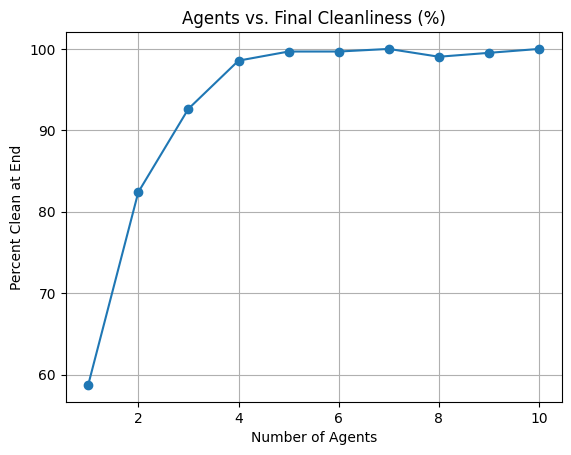

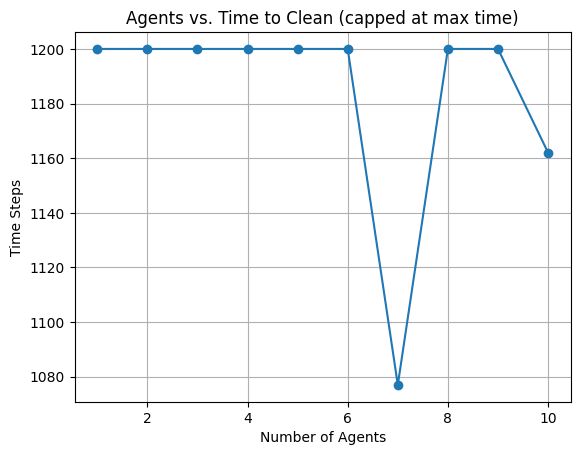

corr(agents, percent_clean_end) = 0.730
corr(agents, time_to_clean) = -0.331


In [131]:
# ===============================================================
# Propósito:
#   Ejecutar corridas experimentales (batch runs) del modelo
#   CleaningModel para evaluar cómo cambia el tiempo de limpieza,
#   porcentaje final limpio y movimientos totales según el número
#   de agentes. Este código está diseñado para notebooks y no
#   requiere DataCollector adicional.
#
# Dependencias:
#   CleaningModel y percent_clean deben haberse definido previamente.
#
# Notas:
#   - Se generan semillas reproducibles para cada corrida.
#   - Se construye un DataFrame con métricas relevantes por experimento.
#   - Incluye visualización básica mediante matplotlib.
# ===============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

# ---------------------------------------------------------------
# Configuración del experimento
# ---------------------------------------------------------------
WIDTH, HEIGHT   = 25, 25   # Dimensiones del cuarto (M x N)
DIRTY_PCT       = 80.0     # Porcentaje inicial de celdas sucias
MAX_TIME        = 1200     # Límite máximo de pasos
START_AGENTS    = 1        # Número inicial de agentes
NUM_RUNS        = 10       # Se correrán agentes = 1..10

agent_counts = list(range(START_AGENTS, START_AGENTS + NUM_RUNS))

# ---------------------------------------------------------------
# Ejecución de corridas experimentales
# ---------------------------------------------------------------
rng = np.random.RandomState(2025)  # Semillas reproducibles por corrida
rows = []

for i, k in enumerate(agent_counts, start=1):

    # Para consistencia experimental, cada modelo podría recibir seed=rng…
    # pero aquí se usa seed=None a propósito para variación interna.
    seed = int(rng.randint(0, 2**31 - 1))

    model = CleaningModel(
        n_agents=k,
        width=WIDTH,
        height=HEIGHT,
        dirty_pct=DIRTY_PCT,
        max_time=MAX_TIME,
        seed=None,  # cambiar a seed=seed si deseas reproducibilidad estricta
    )
    model.run_until_done()

    time_needed = model.time_to_clean if model.time_to_clean is not None else MAX_TIME
    pct_clean   = percent_clean(model)
    total_moves = model.total_moves

    # Se acumulan métricas relevantes por corrida
    rows.append(
        {
            "run": i,
            "agents": k,
            "time_to_clean": time_needed,
            "percent_clean_end": pct_clean,
            "total_moves": total_moves,
            "cleaned_all": model.dirty_cells == 0,
        }
    )

# Convertir resultados en tabla
results_df = pd.DataFrame(rows)

# ---------------------------------------------------------------
# Mostrar tabla (configuración de pandas para mejor lectura)
# ---------------------------------------------------------------
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 120)
display(results_df)

# ---------------------------------------------------------------
# Gráficas: Agentes vs Porcentaje final de limpieza
# ---------------------------------------------------------------
plt.figure()
plt.plot(results_df["agents"], results_df["percent_clean_end"], marker="o")
plt.title("Agents vs. Final Cleanliness (%)")
plt.xlabel("Number of Agents")
plt.ylabel("Percent Clean at End")
plt.grid(True)
plt.show()

# ---------------------------------------------------------------
# Gráficas: Agentes vs Tiempo para Limpiar
# --------------------------------------------------------------- 
plt.figure() 
plt.plot(results_df["agents"], results_df["time_to_clean"], marker="o") 
plt.title("Agents vs. Time to Clean (capped at max time)") 
plt.xlabel("Number of Agents") 
plt.ylabel("Time Steps") 
plt.grid(True) 
plt.show() 


# ---------------------------------------------------------------
# Resultados de correlación
# --------------------------------------------------------------- 
corr_agents_pct = results_df[["agents", "percent_clean_end"]].corr().iloc[0, 1]
corr_agents_time = results_df[["agents", "time_to_clean"]].corr().iloc[0, 1]
print(f"corr(agents, percent_clean_end) = {corr_agents_pct:.3f}")
print(f"corr(agents, time_to_clean) = {corr_agents_time:.3f}")